# Enzyme kinetics at work, a three state continuous-time Markov jump model


We analyzed the dynamics of the three-state Markov process defined by the transitions between states **E**, **ES**, and **EP**. Using the master equations (check theoretical concepts document), we solved for the time-dependent probabilities $\vec{P}(t)$ of being in each state by:

###[i] Numerically integrating the system of ODEs

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
k_plus = 10  # forward rate (Hz)
k_minus = 1  # backward rate (Hz)
t_max = 30  # total integration time (s)
t_eval = np.linspace(0, t_max, 1000)  # time points for evaluation

In [17]:
# Master equation as a system of ODEs
def master_eq(t, P):
    P_E, P_ES, P_EP = P
    dP_E_dt = -(k_plus + k_minus) * P_E + k_minus * P_ES + k_plus * P_EP
    dP_ES_dt = k_plus * P_E - (k_plus + k_minus) * P_ES + k_minus * P_EP
    dP_EP_dt = k_minus * P_E + k_plus * P_ES - (k_plus + k_minus) * P_EP
    return [dP_E_dt, dP_ES_dt, dP_EP_dt]

In [18]:
# Initial conditions: initially all in state E
P0 = [1, 0, 0]

# Solve the system numerically
solution = solve_ivp(master_eq, [0, t_max], P0, t_eval=t_eval)

# Extract probabilities
P_E, P_ES, P_EP = solution.y

#Print probability values as t = 30s
last_values_NI = solution.y[:, -1]
print(last_values_NI)

[0.33334151 0.33339544 0.33326306]


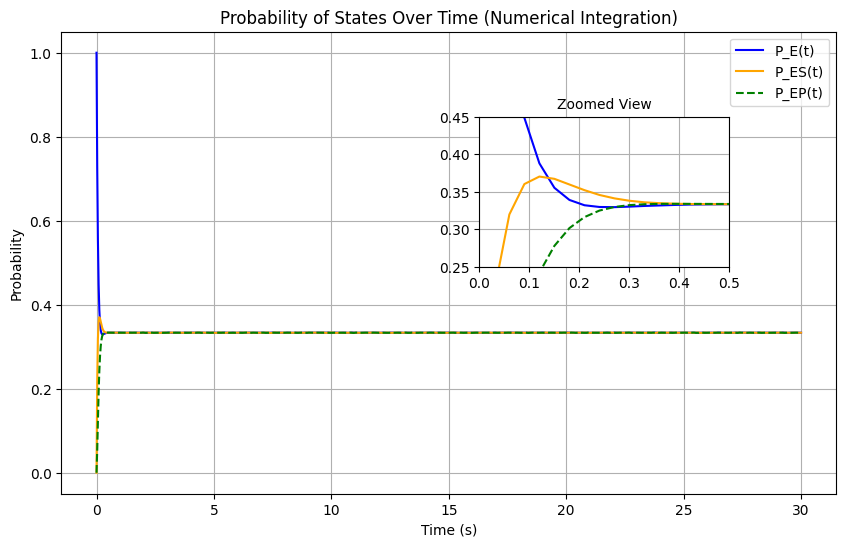

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Plot the results from numerical integration
plt.figure(figsize=(10, 6))
plt.plot(solution.t, P_E, label="P_E(t)", color="blue")
plt.plot(solution.t, P_ES, label="P_ES(t)", color="orange")
plt.plot(solution.t, P_EP, label="P_EP(t)", color="green", linestyle='dashed')
plt.title("Probability of States Over Time (Numerical Integration)")
plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.legend()
plt.grid()

# Add an inset axis for zoomed-in view
ax_inset = inset_axes(plt.gca(), width=2.5, height=1.5, bbox_to_anchor=(0.8, 0.75), bbox_transform=plt.gcf().transFigure)
ax_inset.plot(solution.t, P_E, color="blue")
ax_inset.plot(solution.t, P_ES, color="orange")
ax_inset.plot(solution.t, P_EP, color="green", linestyle='dashed')
ax_inset.set_xlim(0, 0.5)  # Define x-axis limits for zoom
ax_inset.set_ylim(0.25, 0.45)  # Define y-axis limits for zoom
ax_inset.set_title("Zoomed View", fontsize=10)
ax_inset.grid()

plt.show()


###[ii] Stochastic simulation with Gillespie algorithm:

In [20]:
# Gillespie algorithm for the three-state Markov process
def gillespie_algorithm(k_plus, k_minus, t_max, num_trajectories):
    states = ["E", "ES", "EP"]  # E, ES, EP
    num_states = len(states)

    # Rates for each state
    rates = np.array([
        [-k_plus - k_minus, k_minus, k_plus],  # From E
        [k_plus, -k_plus - k_minus, k_minus],  # From ES
        [k_minus, k_plus, -k_plus - k_minus],  # From EP
    ])

    # Time points and probabilities for averaging
    times = np.linspace(0, t_max, 1000)
    dt = t_max / len(times)
    prob_trajectories = np.zeros((len(times), num_states))

    # Simulate multiple trajectories
    for _ in range(num_trajectories):
        t = 0
        state = 0  # Start in state E
        traj_probs = np.zeros((len(times), num_states))
        traj_probs[0, state] = 1  # Initialize at t=0

        for i, t_point in enumerate(times[1:], start=1):
            while t < t_point:
                rates_out = -rates[state, state]
                if rates_out == 0:
                    break
                tau = np.random.exponential(1 / rates_out) #exponential waiting times
                t += tau

                if t >= t_point:
                    break

                # Choose next state based on transition probabilities
                transitions = rates[state, :].copy()
                transitions[state] = 0
                probabilities = transitions / transitions.sum()
                state = np.random.choice(range(num_states), p=probabilities)

            traj_probs[i, state] = 1

        prob_trajectories += traj_probs

    # Average over all trajectories
    avg_probs = prob_trajectories / num_trajectories

    return avg_probs, times, rates

In [21]:
# Parameters for Gillespie algorithm
num_trajectories = 20000

# Run Gillespie simulation
avg_probs, gillespie_times, rates = gillespie_algorithm(
    k_plus, k_minus, t_max, num_trajectories
)

#Print probability values as t = 30s
last_values_SGA = avg_probs[-1,:]
print(last_values_SGA)

[0.3331 0.3326 0.3343]


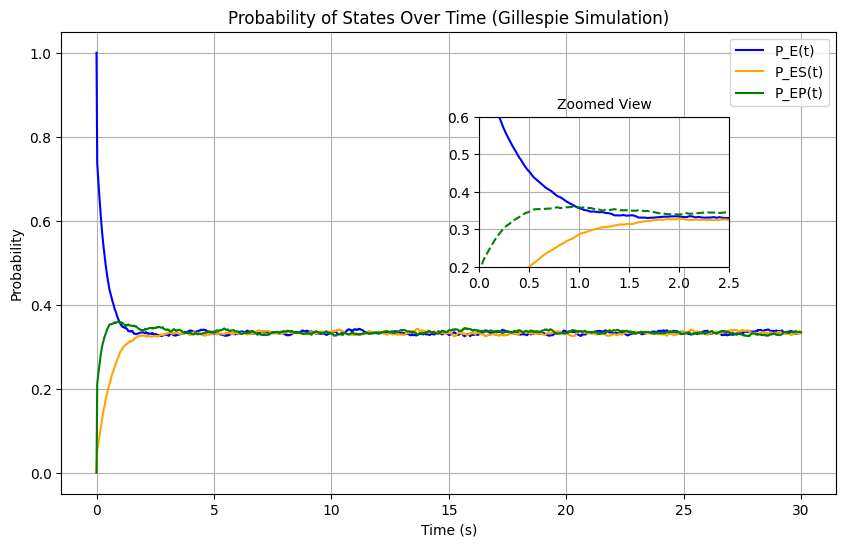

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Plot average probabilities from Gillespie simulation
plt.figure(figsize=(10, 6))
plt.plot(gillespie_times, avg_probs[:, 0], label="P_E(t)", color="blue")
plt.plot(gillespie_times, avg_probs[:, 1], label="P_ES(t)", color="orange")
plt.plot(gillespie_times, avg_probs[:, 2], label="P_EP(t)", color="green")
plt.title("Probability of States Over Time (Gillespie Simulation)")
plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.legend()
plt.grid()

# Add an inset axis for zoomed-in view
ax_inset = inset_axes(plt.gca(), width=2.5, height=1.5, bbox_to_anchor=(0.8, 0.75), bbox_transform=plt.gcf().transFigure)
ax_inset.plot(gillespie_times, avg_probs[:, 0], color="blue")
ax_inset.plot(gillespie_times, avg_probs[:, 1], color="orange")
ax_inset.plot(gillespie_times, avg_probs[:, 2], color="green", linestyle='dashed')
ax_inset.set_xlim(0, 2.5)  # Define x-axis limits for zoom
ax_inset.set_ylim(0.2, 0.6)  # Define y-axis limits for zoom
ax_inset.set_title("Zoomed View", fontsize=10)
ax_inset.grid()

plt.show()

We plotted four stochastic trajectories to highlight the random nature of transitions between states from the Gillespie algorithm method.

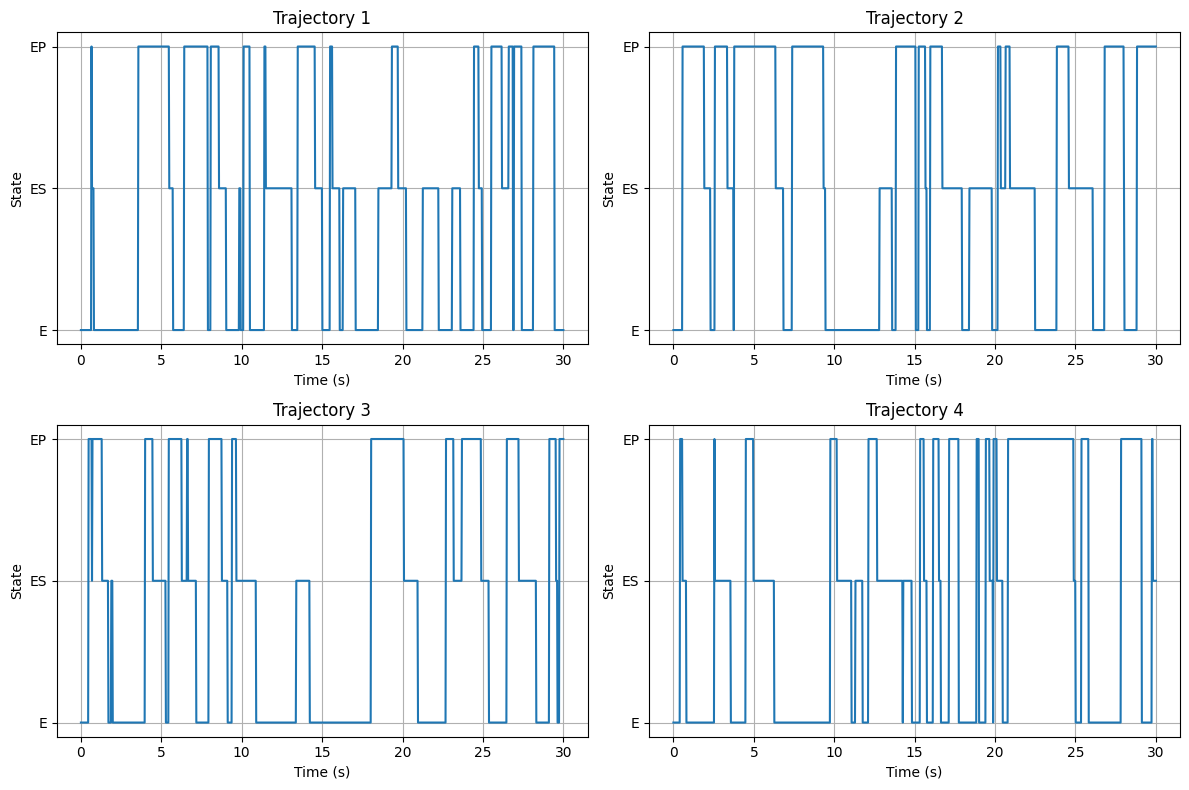

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure for a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loop through the first 4 trajectories and plot on the respective subplots
for i, ax in enumerate(axes.flat):
    if i < num_trajectories:
        t = 0
        state = 0  # Start in state E (state 0 corresponds to "E")
        state_trajectory = []  # List to store the state at each time step
        state_trajectory.append(state)

        for j, t_point in enumerate(gillespie_times[1:], start=1):
            while t < t_point:
                rates_out = -rates[state, state]
                if rates_out == 0:
                    break
                tau = np.random.exponential(1 / rates_out)
                t += tau

                if t >= t_point:
                    break

                # Choose next state based on transition probabilities
                transitions = rates[state, :].copy()
                transitions[state] = 0
                probabilities = transitions / transitions.sum()
                state = np.random.choice(range(3), p=probabilities)

            # Append the current state at this time point
            state_trajectory.append(state)

        # Plot the state trajectory for the i-th subplot
        ax.plot(gillespie_times, state_trajectory, label=f"Trajectory {i+1}")
        ax.set_title(f"Trajectory {i+1}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("State")
        ax.set_yticks([0, 1, 2])  # Label for states E, ES, EP
        ax.set_yticklabels(["E", "ES", "EP"])
        ax.grid(True)

plt.tight_layout()
plt.show()
